In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
import time
import functools
from collections import Counter
#from nxviz import MatrixPlot
from datetime import datetime 
import matplotlib.dates as mdates
import pdb
import matplotlib.ticker as mticker
import pickle
from NetDistr import NetDistr
import seaborn as sb
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
from tqdm import tqdm



In [2]:

def utc_sort_reduce(utc_times, deliminator='T'):

    # takes an unordered list of utc times and removes repeated values and then orders based on tme value
    times_dn = list(set(utc_times))
    times_dn = sorted(times_dn, key = lambda x: datetime.datetime.strptime(x, f'%Y-%m-%d{deliminator}%H:%M:%S'))
    times_dn = [ datetime.datetime.strptime(x, f'%Y-%m-%d{deliminator}%H:%M:%S') for x in np.squeeze(times_dn) ]
    return times_dn


def ulf_power(ulf_power_filename, times, band):
    '''mean ulf powers for pc single band for corespondig times'''
    ulf_powers = pd.read_csv(ulf_power_filename)
    ulf_powers['Date_UTC'] = pd.to_datetime(ulf_powers['Date_UTC'])
    dict_ulf ={'mean_pc_power':[]}
    for i in np.squeeze(times):
        ts = ulf_powers[ulf_powers['Date_UTC'] == i][[ 'Date_UTC', 'IAGA','PC2_IPOW', 'PC3_IPOW', 'PC4_IPOW', 'PC5_IPOW']] 
        powers = ['PC2_IPOW', 'PC3_IPOW', 'PC4_IPOW', 'PC5_IPOW']
        dict_ulf['mean_pc_power'].append(ts[powers[band]].mean())

    return dict_ulf


In [3]:
def plotting_files(filename_handel, ulf_filename, num_stations1, pc_type):
    '''Func to create all plotting data including pivot talbe for undirected and directed networks
    also ulf power from edgelist network files'''
    mlt_lower_lim = 9
    pivot_table_dict = {}
    pivot_table_dict_mlt = {}
    if pc_type == 'Pc2':
        num = 0
    elif pc_type == 'Pc3':
        num = 1
    
    for label in ['dir_net','undir_net_inphase','undir_net_antiphase']:
        pivot_table_dict[label] = []
        pivot_table_dict_mlt[label] = [] 
        netdistr = NetDistr(f'{path}{label}{num}_{filename_handel}.txt', num_stations1)
        pt = netdistr.create_pivottable()
        pt.index = pd.to_datetime(pt.index)
        pivot_table_dict[label] = pt
        pt = netdistr.create_pivottable_by_mlt(mlt_lower_lim)
        pt.index = pd.to_datetime(pt.index)
        pivot_table_dict_mlt[label] = pt
            
            
#   for calculating ulf powers for corespending netowrk times
    times = pivot_table_dict['dir_net'].index
    ulf_dict = ulf_power(ulf_filename, times, num)
    pc_power_arr = ulf_dict['mean_pc_power']

    return pivot_table_dict, pivot_table_dict_mlt, pc_power_arr, times
        

In [27]:
def plot(pivot_table:dict, pivot_table_mlt:dict, pc_power:list, indices_fname:str, y_space:int, save_label:str, pc:str, comp:str, save_plot = False):
    
    plt.rcParams.update({'font.size': 20})
    num_plots = 7
    fig = plt.figure(figsize=(20, 17), constrained_layout=True)
    gs = fig.add_gridspec(num_plots, 3, width_ratios=[30,1,1])
    # fig.suptitle(f'Heatmap plots for {label} netowrks')
    indices = pd.read_csv(indices_fname)
    index_date = indices['Date_UTC']
    sme = indices['SME']
    axsmer = pd.to_datetime(index_date)
    datemin = np.datetime64(index_date.iloc[0])
    datemax = datetime.strptime('2015-03-17T12:00:00', '%Y-%m-%dT%H:%M:%S')

    f1 = fig.add_subplot(gs[0,0])
    f1.plot(axsmer,sme, color='black', label = 'SME')
    f1.set_ylabel('SME (nT)')
    f1.grid()
#   turn off labels for x axis while preserving ticks
    f1.set_xticklabels([])                           
    f1.set_xlim(datemin,datemax)
    formatter = mdates.DateFormatter("%H:%M:%S")
    f1.xaxis.set_major_formatter(formatter)
    f1.legend()
    ax2 = f1.twinx()
    
    # code for plotting SMR sections for entire SMR yearly dataset
    indices['Date_UTC'] = pd.to_datetime(indices['Date_UTC']) 
    
    for i in ['SMR00','SMR06','SMR12','SMR18' ]:
        x = axsmer[(indices['Date_UTC'] >= datemin) & (indices['Date_UTC'] <= datemax)]
        y = indices[(indices['Date_UTC'] >= datemin) & (indices['Date_UTC'] <= datemax)][i]
        ax2.plot(x , y, label= i)

    ax2.xaxis.set_major_formatter(formatter)
    ax2.legend(loc=4)
    ax2.set_ylabel('SMR (nT)')
    ax2.grid()
    ax2.set_xlim(datemin,datemax)
    ax2.set_xticklabels([])

    dyn_pressure = indices['PDYN']
    # GSM field values
    bz, bx, by = indices['GSM_Bz'], indices['GSM_Bx'], indices['GSM_By']
    f2 = fig.add_subplot(gs[1,0])
    f3 = fig.add_subplot(gs[2,0])
    for i in [0,1,2,3]:
        y_vals = [bx, by, bz, dyn_pressure]
        y_labs = ['GSM_Bz','GSM_Bx','GSM_By','Dynamic pressure']
        c = ['red','black','green','orange']
        if i == 3:
            f3.set_ylabel('nPa')
            f3.set_ylim(-10,25)
            # get rid of peaks
            y = np.where( y_vals[i] == np.max(y_vals[i]) , np.nan , y_vals[i])
            f3.plot(axsmer, y, label= y_labs[i], color = c[i])
            f = f3
        else:
            y = np.where( y_vals[i] == np.max(y_vals[i]) , np.nan , y_vals[i])
            f2.plot(axsmer, y, label=y_labs[i], color = c[i])
            f = f2

        f.xaxis.set_major_formatter(formatter)
        f.set_xlim(datemin,datemax)
        f.legend()
        f.grid()
        f.set_xticklabels([])
        f2.set_ylabel('nT')
        f2.set_ylim(-30,30)
        #f2.set_xticklabels([])

    f4 = fig.add_subplot(gs[6,0])
    f4.grid()
    xfmt = mdates.DateFormatter('%H:%M:%S')
    f4.plot(times_arr, pc_power, label= f'{pc} mean power')
    f4.legend(loc=4,markerscale=2)
    f4.xaxis.set_major_formatter(formatter)
    f4.set_xlim(times_arr[0], times_arr[-1])
    f4.set_ylabel('log(nT)^2')
    f4.set_yticks(np.linspace(-1,1,5))

    # plotting heatmaps 
    # tired to use function for plotting heatmaps didn't work
    colour1 = 'Purples_r'
    colour2 = 'Oranges_r'
    y_tick_spacing = y_space 
    x_tick_spacing = 3
    for i, label in enumerate(['dir_net','undir_net_inphase','undir_net_antiphase']):
        i = i + 3 # fig position
        heat_ax1, colorbar_ax1, pt1 = fig.add_subplot(gs[i,0]), fig.add_subplot(gs[i,1]), pivot_table[label]    
        colorbar_ax12, pt1_mlt =  fig.add_subplot(gs[i,2]), pivot_table_mlt[label]
        ax1 = sb.heatmap(pt1.T, xticklabels = x_tick_spacing, yticklabels = y_tick_spacing, ax = heat_ax1, cmap = colour1, 
        cbar_kws={'label': 'frequency'}, cbar_ax = colorbar_ax1)
        ax1.axes.get_xaxis().set_visible(False)
        heat_ax1.grid()
        heat_ax1.text(0.1, 1, f'{label}_{pc}_{comp}', transform= heat_ax1.transAxes, bbox = dict(facecolor = 'white', alpha = 0.5))
        heat_ax1.invert_yaxis()
        heat_ax1.set_ylabel('degrees')
        heat_ax1.set_facecolor('grey')
        ax1 = sb.heatmap(pt1_mlt.T, xticklabels = x_tick_spacing, yticklabels = y_tick_spacing, ax = heat_ax1, cmap = colour2, 
        cbar_kws={'label': 'freq. MLT>9 hrs'}, cbar_ax = colorbar_ax12)
        ax1.axes.get_xaxis().set_visible(False)
        heat_ax1.grid()
        heat_ax1.invert_yaxis()
        heat_ax1.set_ylabel('degrees')
        heat_ax1.set_facecolor('grey')
    
    if save_plot:
        plt.savefig(f'plots/{save_label}_{comp}_nets.png', facecolor='w')

    plt.show()

In [28]:
# handel for labeling anlysis files for each event, period multiple for window and 0.3 being peak height
comp='n'
w_inc = 20
peakh = 0.3
event_id = '2015'
num_stations = 128
# dir_net0_n_20_peakh_0.3_num_stations_128_2015
fhandel = f'{comp}_{w_inc}_peakh_{peakh}_num_stations_{num_stations}_{event_id}'
path = f'networks_data/2015_nets/comp_{comp}/'
ulf_fname = 'networks_data/ulf_spd_2015.csv'

# pivot_table_dict, pivot_table_dict_mlt, pc_power_arr, times_arr = plotting_files(
#     fhandel, ulf_fname, 122, 'Pc2')


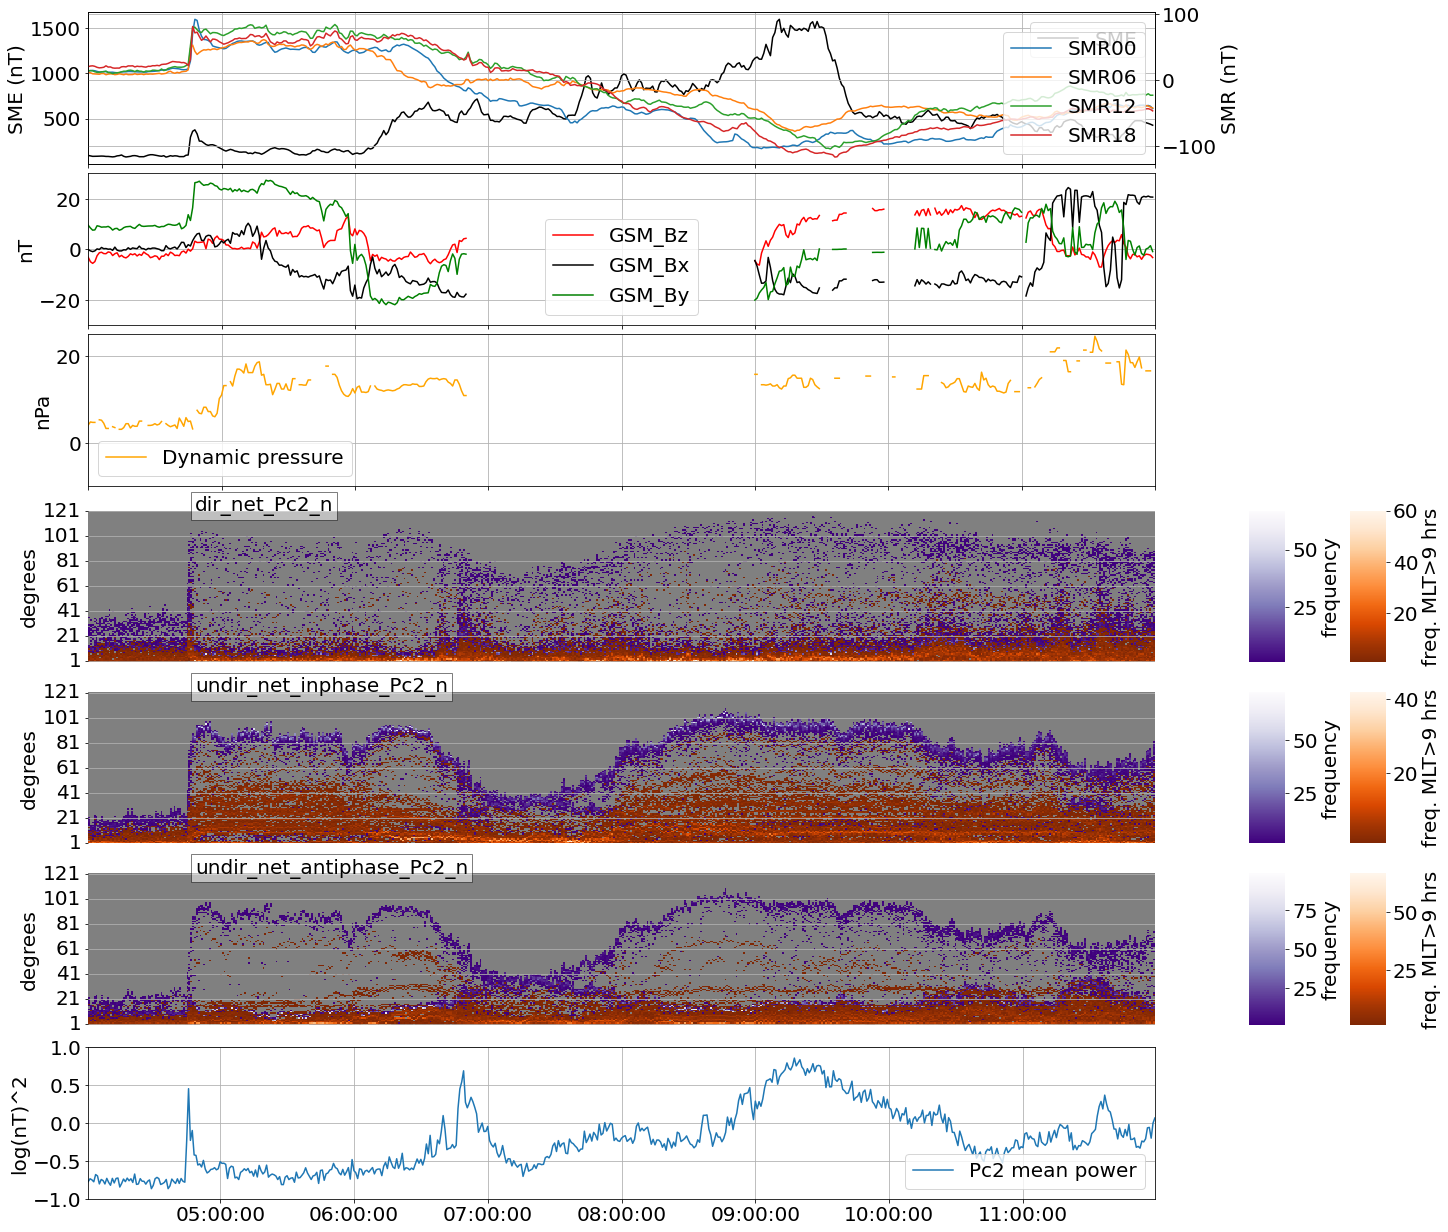

In [29]:
indices_fname = 'networks_data/indices_spd_2015.csv'
plot(pivot_table_dict, pivot_table_dict_mlt, pc_power_arr, 
     indices_fname, y_space=20, save_label=fhandel, pc='Pc2', comp = comp ,save_plot=True)